In [90]:
from ipywidgets import FileUpload
from IPython.display import Audio
import tempfile
import soundfile as sf
import io   
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from glob import glob
import librosa
import librosa.display
import IPython.display as ipd

In [4]:
upload = FileUpload(accept="audio/*", multiple=False)

In [5]:
display(upload)

FileUpload(value=(), accept='audio/*', description='Upload')

In [54]:
print(upload)

FileUpload(value=({'name': 'M02_LT_z01.wav', 'type': 'audio/wav', 'size': 38678, 'content': <memory at 0x00000204A53BF580>, 'last_modified': datetime.datetime(2024, 3, 20, 8, 2, 13, 985000, tzinfo=datetime.timezone.utc)},), accept='audio/*', description='Upload')


In [55]:
uploaded_file = upload.value[0]
audio_content = uploaded_file['content']
audio_np = np.frombuffer(audio_content, dtype=np.int16)

In [56]:
with sf.SoundFile(io.BytesIO(audio_content)) as audio:
    sample_rate = audio.samplerate

sample_rate

11025

In [57]:
with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as tmp_file:
    tmp_filename = tmp_file.name
    sf.write(tmp_filename, audio_np, samplerate=sample_rate)

In [58]:
with sf.SoundFile(tmp_filename) as audio:
    diskretizacijos_daznis = audio.samplerate
    kanalu_skaicius = audio.channels
    kvantavimo_bitai = audio.subtype

print(f"Diskretizavimo daznis: {diskretizacijos_daznis}")
print(f"Kanalu skaicius: {kanalu_skaicius}")
print(f"Kvantavimo bitu skaicius: {kvantavimo_bitai}")

Diskretizavimo daznis: 11025
Kanalu skaicius: 1
Kvantavimo bitu skaicius: PCM_16


In [59]:
display(Audio(filename=tmp_filename))

In [60]:
y, sr = librosa.load(tmp_filename, sr=sample_rate)
y_trimmed = y[int(0.01 * sr):]
duration_in_seconds = len(y_trimmed) / sr
time_in_milliseconds = pd.Series(range(len(y_trimmed))) * (duration_in_seconds / len(y_trimmed)) * 1000
audio_series = pd.Series(y_trimmed, index=time_in_milliseconds)

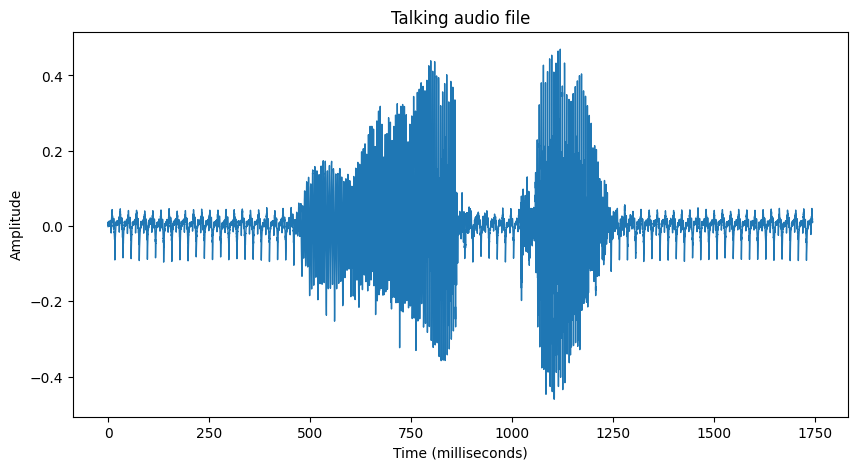

In [61]:
audio_series.plot(figsize=(10, 5), lw=1, title='Talking audio file')
plt.xlabel('Time (milliseconds)')
plt.ylabel('Amplitude')
plt.show()

In [62]:
def calculate_frame_energy(signal, frame_length, hop_length):
    energy = []
    # Iterate over the signal with the given hop length
    for start in range(0, len(signal) - frame_length + 1, hop_length):
        # Compute the energy of the current frame
        current_frame_energy = np.sum(signal[start:start+frame_length] ** 2)
        energy.append(current_frame_energy)
    return np.array(energy)

In [63]:
frame_length_ms = 15
frame_length_samples = int(frame_length_ms / 1000 * sample_rate)

In [64]:
# Define the hop length (50% of the frame length)
hop_length_samples = frame_length_samples // 2

In [65]:
# Calculate the energies of the frames using the trimmed audio signal
frame_energies = calculate_frame_energy(y_trimmed, frame_length_samples, hop_length_samples)

In [66]:
# Time vector for plotting, in seconds
time_vector_seconds = np.arange(len(frame_energies)) * hop_length_samples / sample_rate

In [72]:
# Convert time vector to milliseconds
time_vector_milliseconds = time_vector_seconds * 1000

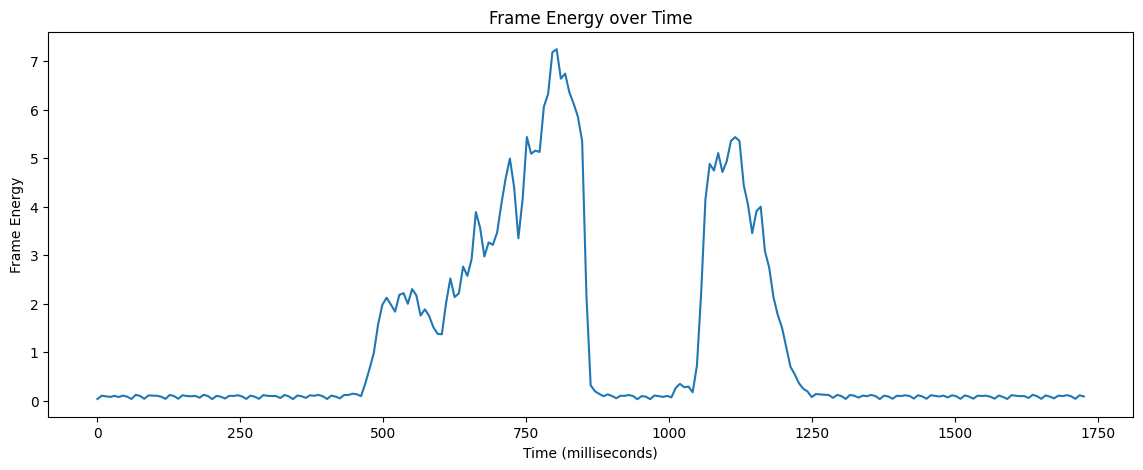

In [73]:
plt.figure(figsize=(14, 5))
plt.plot(time_vector_milliseconds, frame_energies)
plt.xlabel('Time (milliseconds)')
plt.ylabel('Frame Energy')
plt.title('Frame Energy over Time')
plt.show()

In [74]:
def calculate_zero_crossings(signal, frame_length, hop_length):
    # Initialize the zero-crossing array
    zero_crossings = np.zeros(int(len(signal) / hop_length))
    # Iterate over the signal with the given hop length
    for i in range(0, len(zero_crossings)):
        start = i * hop_length
        end = start + frame_length
        frame = signal[start:end]
        # The signum function is applied to the frame to determine whether each sample is positive (+1), zero (0), or negative (-1).
        signum_frame = np.sign(frame)
        # Calculate the zero crossings within this frame
        zero_crossings[i] = np.sum(np.abs(np.diff(signum_frame))) / (2 * frame_length)
    return zero_crossings

In [75]:
# Calculate the zero-crossing rate for the trimmed audio signal
frame_length = 30
hop_length = 15
zcr = calculate_zero_crossings(y_trimmed, frame_length, hop_length)
print(zcr[0:1000])

[0.03333333 0.06666667 0.06666667 0.         0.03333333 0.06666667
 0.03333333 0.         0.1        0.16666667 0.06666667 0.
 0.         0.1        0.1        0.         0.         0.
 0.         0.06666667 0.06666667 0.         0.         0.
 0.1        0.1        0.         0.         0.1        0.1
 0.26666667 0.26666667 0.         0.         0.06666667 0.06666667
 0.         0.         0.16666667 0.23333333 0.03333333 0.
 0.         0.03333333 0.03333333 0.         0.         0.
 0.         0.06666667 0.06666667 0.         0.         0.13333333
 0.16666667 0.03333333 0.         0.         0.03333333 0.1
 0.06666667 0.         0.         0.03333333 0.06666667 0.03333333
 0.         0.03333333 0.06666667 0.13333333 0.06666667 0.
 0.06666667 0.1        0.         0.         0.         0.
 0.03333333 0.06666667 0.03333333 0.         0.13333333 0.3
 0.2        0.         0.         0.16666667 0.16666667 0.06666667
 0.06666667 0.         0.         0.06666667 0.06666667 0.
 0.         0

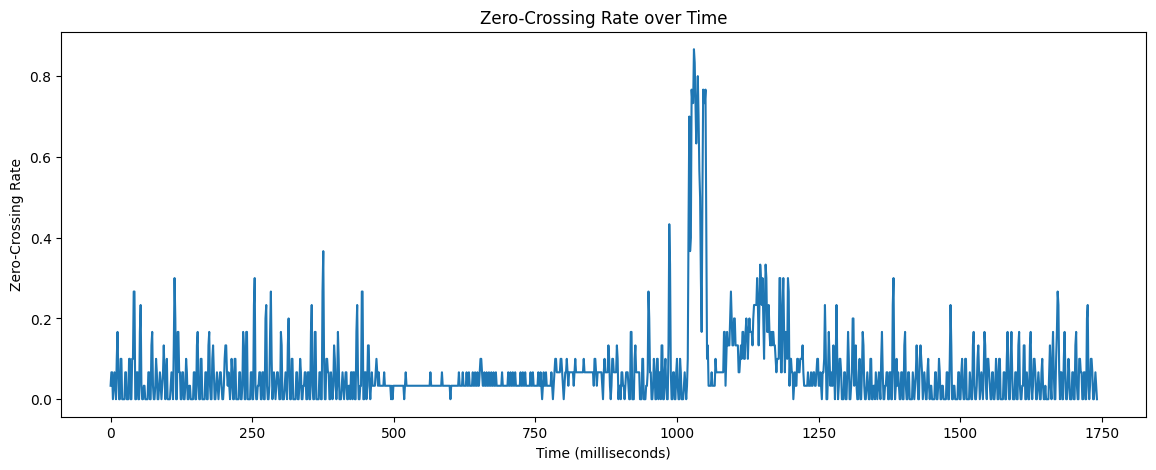

In [76]:
time_vector = np.arange(len(zcr)) * hop_length / sr * 1000
plt.figure(figsize=(14, 5))
plt.plot(time_vector, zcr)
plt.xlabel('Time (milliseconds)')
plt.ylabel('Zero-Crossing Rate')
plt.title('Zero-Crossing Rate over Time')
plt.show()

## Vokalizuotas garsas

In [83]:
start_in_miliseconds = 750
end_in_miliseconds = 775

start_sample = int(sr * start_in_miliseconds/1000)
end_sample = int(sr * end_in_miliseconds/1000)

y_segment = y[start_sample:end_sample]
time_in_miliseconds = (pd.Series(range(start_sample, end_sample)) - start_sample) * (1000.0 / sr)
audio_series_segment = pd.Series(y_segment, index=time_in_miliseconds)

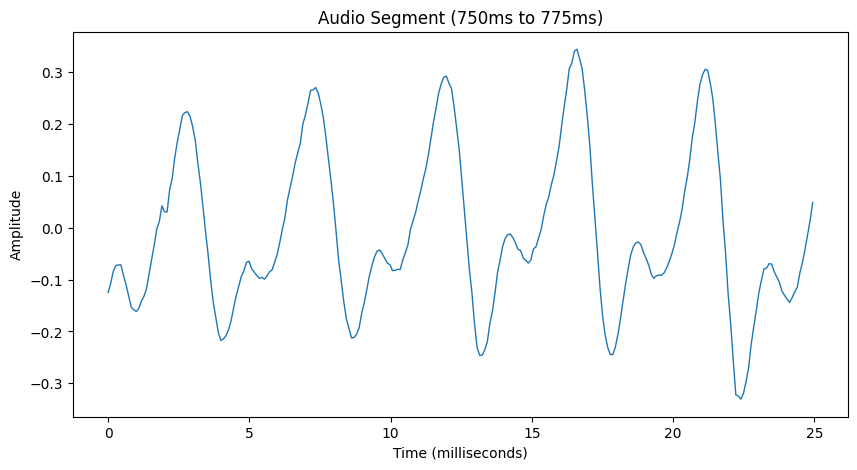

In [84]:
audio_series_segment.plot(figsize=(10, 5), lw=1, title=f'Audio Segment ({start_in_miliseconds}ms to {end_in_miliseconds}ms)')
plt.xlabel('Time (milliseconds)')
plt.ylabel('Amplitude')
plt.show()

## Triukšmas

In [87]:
start_in_miliseconds = 5
end_in_miliseconds = 30

start_sample = int(sr * start_in_miliseconds/1000)
end_sample = int(sr * end_in_miliseconds/1000)

y_segment = y[start_sample:end_sample]
time_in_miliseconds = (pd.Series(range(start_sample, end_sample)) - start_sample) * (1000.0 / sr)
audio_series_segment = pd.Series(y_segment, index=time_in_miliseconds)

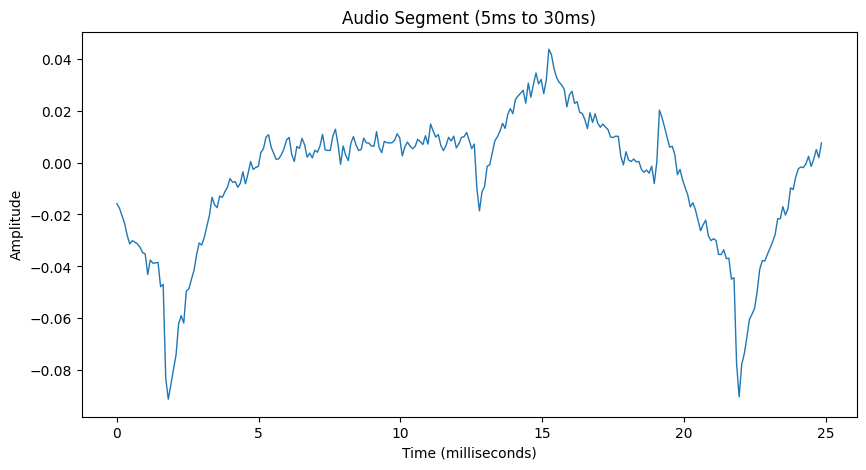

In [88]:
audio_series_segment.plot(figsize=(10, 5), lw=1, title=f'Audio Segment ({start_in_miliseconds}ms to {end_in_miliseconds}ms)')
plt.xlabel('Time (milliseconds)')
plt.ylabel('Amplitude')
plt.show()

## Nevokalizuotas garsas

In [112]:
audio_files_talking = glob('../lab1/SeeYouAgain.wav')
audio_talking = audio_files_talking[0]
print(audio_talking)

../lab1/SeeYouAgain.wav


In [114]:
with sf.SoundFile(audio_talking) as audio:
    diskretizacijos_daznis = audio.samplerate

diskretizacijos_daznis

8000

In [115]:
ipd.Audio(audio_talking)

In [116]:
y, sr = librosa.load(audio_talking, sr=None)
duration_in_seconds = len(y) / sr
time_in_milliseconds = pd.Series(range(len(y))) * (duration_in_seconds / len(y)) * 1000
audio_series = pd.Series(y, index=time_in_milliseconds)

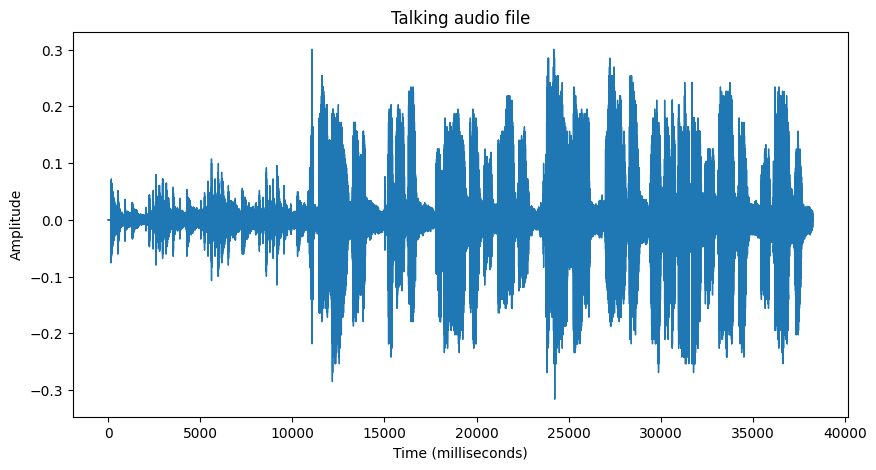

In [117]:
audio_series.plot(figsize=(10, 5), lw=1, title='Talking audio file')
plt.xlabel('Time (milliseconds)')
plt.ylabel('Amplitude')
plt.show()

In [118]:
start_in_miliseconds = 400
end_in_miliseconds = 450

start_sample = int(sr * start_in_miliseconds/1000)
end_sample = int(sr * end_in_miliseconds/1000)

y_segment = y[start_sample:end_sample]
time_in_miliseconds = (pd.Series(range(start_sample, end_sample)) - start_sample) * (1000.0 / sr)
audio_series_segment = pd.Series(y_segment, index=time_in_miliseconds)

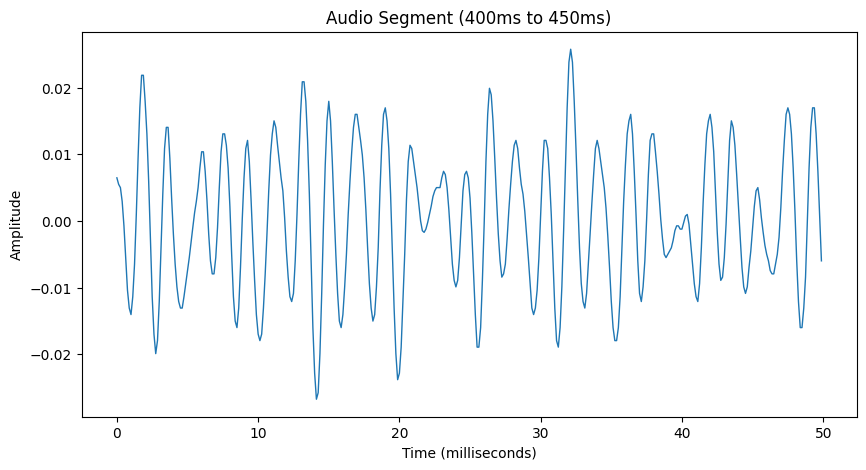

In [119]:
audio_series_segment.plot(figsize=(10, 5), lw=1, title=f'Audio Segment ({start_in_miliseconds}ms to {end_in_miliseconds}ms)')
plt.xlabel('Time (milliseconds)')
plt.ylabel('Amplitude')
plt.show()